# Load multimodal humor datasets from Hugging Face

Import the New Yorker Caption Contest dataset from Hugging Face Hub directly into Pixeltable tables.

**What's in this recipe:**
- Import Hugging Face datasets with images and text
- Automatic schema inference from dataset structure
- Work with humor understanding and image captioning datasets

## Problem

The [New Yorker Caption Contest](https://huggingface.co/datasets/jmhessel/newyorker_caption_contest) dataset contains cartoons with captions for humor understanding tasks. You need this multimodal dataset in Pixeltable to apply AI models, analyze humor patterns, or train caption generation models.

## Solution

You import Hugging Face datasets directly into Pixeltable tables using `pxt.create_table()` with the `source` parameter. This automatically infers the schema and loads the data, where you can immediately apply AI models and query results.

You can iterate on transformations before adding them to your table. Use `.select()` with `.collect()` to preview results on sample data—nothing is stored in your table. If you want to collect only the first few rows, use `.head(n)` instead of `.collect()`. Once you're satisfied, use `.add_computed_column()` to apply transformations to all rows in your table.

For more on this workflow, see [Get fast feedback on transformations](./dev-iterative-workflow.ipynb).

### Setup

In [1]:
!uv add pixeltable datasets

Resolved 261 packages in 3ms
Audited 164 packages in 18ms


Load the explanation task from the [New Yorker Caption Contest](https://huggingface.co/datasets/jmhessel/newyorker_caption_contest) dataset. This task contains cartoons with captions and explanations of why they're funny.

In [2]:
import datasets

# Load the explanation task - cartoons with joke explanations
caption_dataset = datasets.load_dataset(
    'jmhessel/newyorker_caption_contest',
    'explanation',
    split='train'
)

### Create Pixeltable table

Create a directory and table, then let Pixeltable automatically infer the schema and import the data.

In [3]:
import pixeltable as pxt

# Create a fresh directory (drop existing if present)
pxt.drop_dir('caption_contest', force=True)
pxt.create_dir('caption_contest')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata
Created directory 'caption_contest'.


In [4]:
# Create table with explicit schema
t = pxt.create_table(
    'caption_contest.explanations',
    schema={
        'image': pxt.Image,
        'contest_number': pxt.Int,
        'image_location': pxt.String,
        'image_description': pxt.String,
        'caption_choices': pxt.String,
        'label': pxt.String
    },
    comment='New Yorker Caption Contest cartoons with captions and humor explanations from Hugging Face'
)

Created table 'explanations'.


In [5]:
# Prepare rows for insertion from Hugging Face dataset
# Note: Same cartoons appear multiple times with different caption choices (that's the contest!)
rows = []
for item in caption_dataset:
    rows.append({
        'image': item['image'],
        'contest_number': item['contest_number'],
        'image_location': item['image_location'],
        'image_description': item['image_description'],
        'caption_choices': item['caption_choices'],
        'label': item['label']
    })

# Insert the data
t.insert(rows)

Inserting rows into `explanations`: 2340 rows [00:01, 1191.99 rows/s]
Inserted 2340 rows with 0 errors.


2340 rows inserted, 14040 values computed.

image,caption_choices,image_description
,He has a summer job as a scarecrow.,"Two women are looking out a window. There is snow outside, and there is a snowman with human arms."
,You promised me you would stop after you lost your arm from that paper cut!,A man and a woman are in a room with a regular looking bookshelf and regular sized books on the wall. In the middle of the room the man is pointing to text written on a giant open book which covers the entire floor. He is talking while the woman watches from the doorway.
,"The pen is mightier, but that looks awesome.",There are two men in suits standing at the door of an office both looking at a desk with a medieval sword stuck into the middle of the desk. One man is talking.

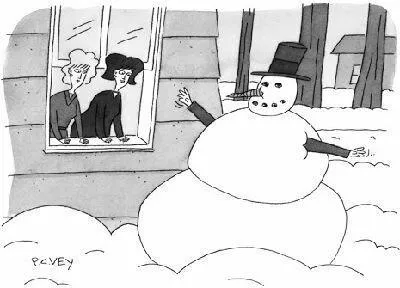
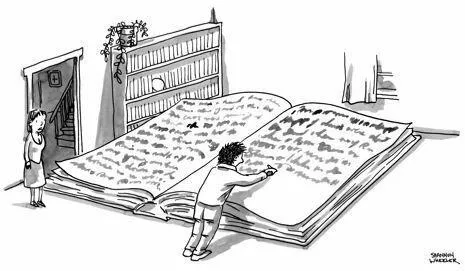
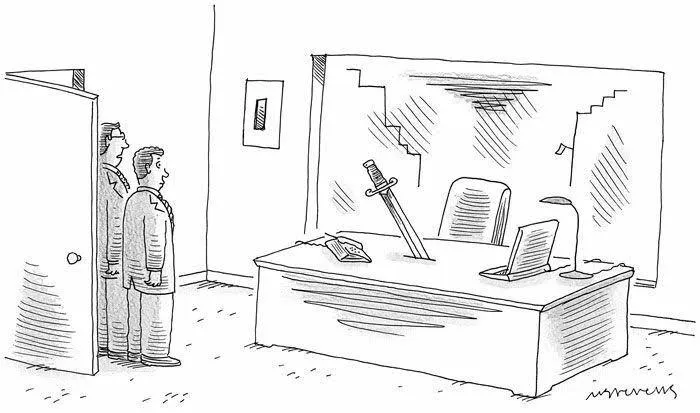

In [6]:
# View imported data - images, captions, and explanations
t.select(t.image, t.caption_choices, t.image_description).head(3)

In [7]:
# Check total count
t.count()

2340

### Add AI Features

Add CLIP embeddings for image similarity search.


In [8]:
# Add CLIP embeddings for image similarity search
from pixeltable.functions.huggingface import clip

t.add_embedding_index(
    'image',
    embedding=clip.using(model_id='openai/clip-vit-base-patch32')
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


image,contest_number,sim
,101,0.819
,120,0.806
,484,0.802
,30,0.801
,243,0.8

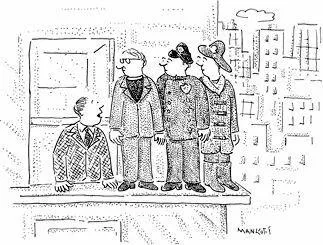
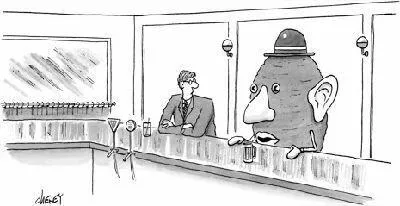
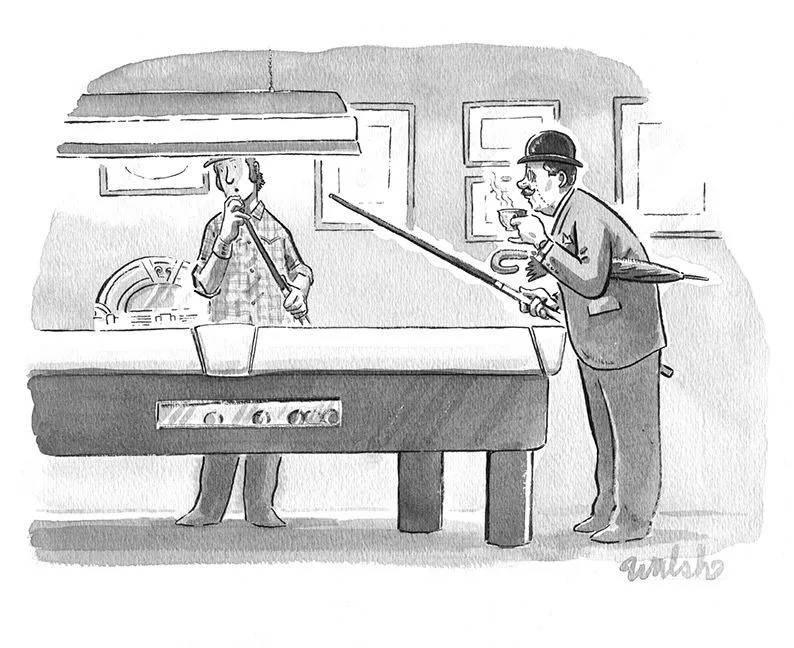
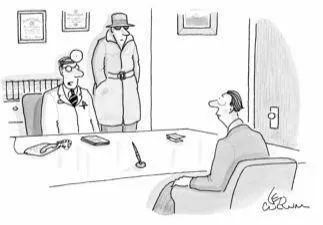
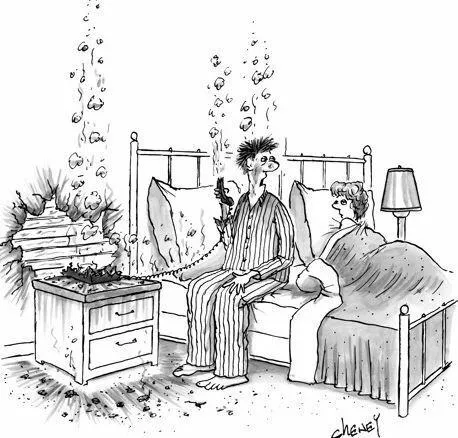

In [14]:
# Test similarity search - find cartoons with similar visual style
# Pick a sample cartoon to search for similar ones
sample_img = t.select(t.image).head(1)[0]['image']
sim = t.image.similarity(sample_img)

# Filter out perfect matches and group by contest to see unique similar cartoons
# Use group_by to get one entry per unique cartoon
t.where(sim <= 0.9999).group_by(t.contest_number).order_by(sim, asc=False).limit(5).select(t.image, t.contest_number, sim=sim).collect()

### Publish to Pixeltable Cloud

Share your dataset publicly on Pixeltable Cloud for others to replicate and use.


In [15]:
# Publish the table to Pixeltable Cloud
pxt.publish(
    'caption_contest.explanations',
    'pxt://pixeltable:hugging-face/newyorker_caption_contest',
    access='public'
)

Creating a replica of 'caption_contest.explanations' at: pxt://pixeltable:hugging-face/newyorker_caption_contest
Uploading: 100%|█████████████████████████████████████████████████| 100M/100M [00:04<00:00, 22.7MB/s]
Finalizing replica ...
The published table is now available at: pxt://pixeltable:hugging-face/newyorker_caption_contest


## See also

- [New Yorker Caption Contest Dataset on Hugging Face](https://huggingface.co/datasets/jmhessel/newyorker_caption_contest)
- [Working with Embedding and Vector Indexes](https://docs.pixeltable.com/tutorials/embedding-indexes)
- [Hugging Face Integration](https://docs.pixeltable.com/api/functions/huggingface)